In [3]:
import pulp
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from ortools.linear_solver import pywraplp

In [6]:
data = pd.read_csv("./family_data.csv", index_col='family_id')
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


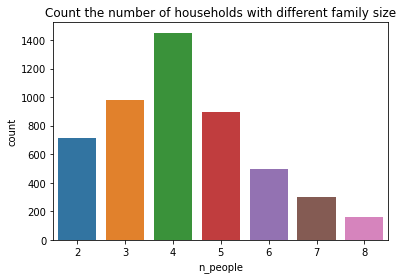

In [7]:
ax = sns.countplot(data=data, x='n_people')
ax.set_title("Count the number of households with different family size")
plt.show()

In [8]:
def get_penalty(n, choice):
    if choice == 0:
        penalty = 0
    elif choice == 1:
        penalty = 50
    elif choice == 2:
        penalty = 50 + 9 * n
    elif choice == 3:
        penalty = 100 + 9 * n
    elif choice == 4:
        penalty = 200 + 9 * n
    elif choice == 5:
        penalty = 200 + 18 * n
    elif choice == 6:
        penalty = 300 + 18 * n
    elif choice == 7:
        penalty = 300 + 36 * n
    elif choice == 8:
        penalty = 400 + 36 * n
    elif choice == 9:
        penalty = 500 + (36 + 199) * n
    else:
        penalty = 500 + (36 + 398) * n
    return penalty

In [9]:
N_DAYS = 100 # 安排的天数
N_FAMILY = 5000 # 家庭ID个数
MIN_OCCUPANCY = 125 # 最小承载量
MAX_OCCUPANCY = 300 # 最大承载量

In [10]:
# 计算pcost_mat, 每个家庭，在什么时候(day 0-99)访问时的penalty
pcost_mat = np.full(shape=(N_FAMILY, 100), fill_value=99999)

for f in range(N_FAMILY):
    #  家庭成员数
    f_num = data.loc[f, 'n_people']
    # 对滴f个家庭，初始化pcost_mat 为other choice下的penalty
    pcost_mat[f, :] = get_penalty(f_num, 10)
    # 计算choice 0-9的penalty
    for choice in range(10):
        temp = data.loc[f][choice] # choice的天数
        penalty = get_penalty(f_num, choice)
        pcost_mat[f, temp-1] = penalty
        
pcost_mat

array([[2236, 2236, 2236, ..., 2236, 2236, 2236],
       [2236, 2236, 2236, ..., 2236, 2236, 2236],
       [1802, 1802, 1802, ..., 1802, 1802,    0],
       ...,
       [3104, 3104,  616, ..., 3104, 3104, 3104],
       [ 390, 2670, 2670, ..., 2670, 2670, 2670],
       [2236, 2236, 2236, ..., 2236, 2236, 2236]])

In [11]:
# 计算accounting penalty 矩阵, 前一天的参观人数，当天的参观人数
acost_mat = np.zeros((500, 500), dtype=np.float64)

for i in range(acost_mat.shape[0]):  # 当天安排的人数
    for j in range(acost_mat.shape[1]):  # 前一天安排的人数
        diff = abs(i - j)
        acost_mat[i, j] = max(0, (i - 125) / 400 * i**(0.5 + diff / 50))
        
acost_mat  

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.31354104e+28, 1.16015634e+28, 1.02468267e+28, ...,
        2.07329520e+01, 2.34740633e+01, 2.65775778e+01],
       [1.52288730e+28, 1.34500277e+28, 1.18789647e+28, ...,
        2.35617801e+01, 2.08095894e+01, 2.35617801e+01],
       [1.76565289e+28, 1.55934897e+28, 1.37715019e+28, ...,
        2.67784790e+01, 2.36496052e+01, 2.08863179e+01]])

In [12]:
FAMILY_SIZE = data['n_people'].values
FAMILY_SIZE

array([4, 4, 3, ..., 6, 5, 4], dtype=int64)

In [13]:
# DESIRED 代表每个家庭choice-1
# pcost_mat 的day是1-100， 对应的下标是0-99
DESIRED = data.values[:, :-1] - 1
DESIRED

array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]], dtype=int64)

In [16]:
# 线性规划
def solveLP():
    solver = pywraplp.Solver('AssigmentProblem',
                             pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    x = {}  # family_id 在第j天是否参观
    # 每一天有哪些家庭
    caditates = [[] for _ in range(N_DAYS)]

    for i in range(N_FAMILY):  # family_id
        for j in DESIRED[i, :]:  # family_id的choice
            caditates[j].append(i)  # 第j天， 有i个family参观
            # 定义决策变量 x[i,j] i 代表family_id, j 代表第j天参观
            x[i, j] = solver.BoolVar('x[%i, %i]' % (i, j))

    # 每天参观的人数 100个数 x[i,j] = 0 或 1
    daily_occupancy = [
        solver.Sum([x[i, j] * FAMILY_SIZE[i] for i in caditates[j]])
        for j in range(N_DAYS)
    ]  # j 代表1-100天

    # 每个家庭，在10个choice中出现的总数
    family_presence = [
        solver.Sum(x[i, j] for j in DESIRED[i, :]) for i in range(N_FAMILY)
    ]

    # 定义目标函数
    preference_cost = solver.Sum([
        pcost_mat[i, j] * x[i, j] for i in range(N_FAMILY)
        for j in DESIRED[i, :]
    ])
    
    # 满足preference_cost最小
    solver.Minimize(preference_cost)

    # 人为增加约束条件
    for j in range(N_DAYS - 1):
        # 当前人数不超过前一天人数+25
        solver.Add(daily_occupancy[j] - daily_occupancy[j + 1] <= 25)
        solver.Add(daily_occupancy[j + 1] - daily_occupancy[j] <= 25)

    # 每个家庭都在10个choice中出现1次
    for i in range(N_FAMILY):
        solver.Add(family_presence[i] == 1)

    # 每天访问人数约束
    for j in range(N_DAYS):
        solver.Add(daily_occupancy[j] >= MIN_OCCUPANCY)
        solver.Add(daily_occupancy[j] <= MAX_OCCUPANCY)

    res_status = solver.Solve()
    if res_status == 0:
        print('总score:', solver.Objective().Value())
        temp = [(i, j, x[i, j].solution_value()) for i in range(N_FAMILY)
                for j in DESIRED[i, :] if x[i, j].solution_value() > 0]
        df = pd.DataFrame(temp, columns=['family_id', 'day', 'result'])
    else:
        df = None
    return df

In [17]:
lp_df = solveLP()

总score: 73702.31696428571
